# 19.1 VSTOXX 데이터

VSTOXX 변동성 지수의 모형으로는 square_root_diffusion 클래스를 사용
& 다음과 같은 점을 고려하여 구현

1. DATA 수집
    - VSTOXX 지수뿐 아니라 이 지수를 기초자산으로 하는 선물과 옵션, 세 가지 유형의 자료가 필요
   
2. 모형 캘리브레이션
    - 시장에서 거래되지 않는 옵션의 가치 평가를 위해선 모형에 사용되는 파라미터들이 현재 거래되는 옵션 가격을 최대한 유사하게 할 수 있는 값을 가지도록 캘리브레이션 해야함

3. 포트폴리오 가치 평가
    - VSTOXX 변동성 지수를 기초자산으로 하고 시장 가격에 캘리브레이션된 자료 및 모형이 있다면 현재 거래되지 않는 옵션을 모형화하고 가치 평가 할 수 있음

## 19.1.1 VSTOXX 지수 데이터 
VSTOXX를 기초자산으로 하는 아메리칸 풋 옵션을 가치 평가하기 위해 필요한 자료 수집

In [1]:
import numpy as np
import pandas as pd

In [2]:
url = 'http://www.stoxx.com/download/historical_values/h_vstoxx.txt'

In [3]:
vstoxx_index = pd.read_csv(url, index_col = 0, header = 2, parse_dates = True, dayfirst = True)

In [4]:
vstoxx_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4357 entries, 1999-01-04 to 2016-02-12
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V2TX    4357 non-null   float64
 1   V6I1    3906 non-null   float64
 2   V6I2    4357 non-null   float64
 3   V6I3    4296 non-null   float64
 4   V6I4    4357 non-null   float64
 5   V6I5    4357 non-null   float64
 6   V6I6    4340 non-null   float64
 7   V6I7    4357 non-null   float64
 8   V6I8    4343 non-null   float64
dtypes: float64(9)
memory usage: 340.4 KB


2014년 1사분기 자료 사용 -> 그 외 자료는 삭제

In [5]:
vstoxx_index = vstoxx_index[('2013/12/31' < vstoxx_index.index) & (vstoxx_index.index < '2014/4/1')]

자료를 보면 V2TX의 일간 종가뿐 아니라 V6I1에서 V6I8까지의 보조 지수의 자료도 존재.

* 기호의 마지막 숫자는 만기를 표시(1 = 가장 가까운 만기, 8 = 가장 먼 만기)
* 여기서 지수는 V6I1과 V6I2를 내삽한 값(1 : 30일 이내의 만기, 2 : 30일부터 60일 사이의 만기)

In [6]:
np.round(vstoxx_index.tail(), 2)

,V2TX,V6I1,V6I2,V6I3,V6I4,V6I5,V6I6,V6I7,V6I8
Date,,,,,,,,,
2014-03-25,18.26,18.23,18.31,19.04,19.84,20.31,18.11,20.83,21.20
2014-03-26,17.59,17.48,17.70,18.45,19.42,20.00,20.26,20.45,20.86
2014-03-27,17.64,17.50,17.76,18.62,19.49,20.05,20.11,20.49,20.94
2014-03-28,17.03,16.68,17.29,18.33,19.30,19.83,20.14,20.38,20.82
2014-03-31,17.66,17.61,17.69,18.57,19.43,20.04,19.98,20.44,20.90


## 19.1.2 VSTOXX 선물 데이터

In [7]:
vstoxx_futures = pd.read_excel('/Users/anrnd/Desktop/파이썬 금융분석/vstoxx_march_2014.xlsx','vstoxx_futures')

C:\Users\anrnd\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
vstoxx_futures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   A_DATE                     504 non-null    datetime64[ns]
 1   A_EXP_YEAR                 504 non-null    int64         
 2   A_EXP_MONTH                504 non-null    int64         
 3   A_CALL_PUT_FLAG            504 non-null    object        
 4   A_EXERCISE_PRICE           504 non-null    int64         
 5   A_SETTLEMENT_PRICE_SCALED  504 non-null    int64         
 6   A_PRODUCT_ID               504 non-null    object        
 7   SETTLE                     504 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 31.6+ KB


In [9]:
del vstoxx_futures['A_SETTLEMENT_PRICE_SCALED']
del vstoxx_futures['A_CALL_PUT_FLAG']
del vstoxx_futures['A_EXERCISE_PRICE']
del vstoxx_futures['A_PRODUCT_ID']

In [10]:
columns = ['DATE', 'EXP_YEAR', 'EXP_MONTH', 'PRICE']
vstoxx_futures.columns = columns

거래소에서 거래되는 옵션 만기일이 매 만기 월의 세번째 금요일 -> 연도와 월 입력하면 세번째 금요일 날짜를 출력해주는 보조 함수 필요

In [11]:
import datetime as dt
import calendar

In [12]:
def third_friday(date):
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 2) % 7
    return dt.datetime(date.year, date.month, day)

In [13]:
# vstoxx 선물이나 옵션은 언제나 현재 달의 세 번째 금요일과 다음 달의 세 번째 금요일을 포함하여 8개의 만기 존재
# 2014년 1월 부터 2014년 11월 까지 11개의 만기 존재

set(vstoxx_futures['EXP_MONTH'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [14]:
third_fridays = {}
for month in set(vstoxx_futures['EXP_MONTH']):
        third_fridays[month] = third_friday(dt.datetime(2014, month, 1))

third_fridays

{1: datetime.datetime(2014, 1, 17, 0, 0),
 2: datetime.datetime(2014, 2, 21, 0, 0),
 3: datetime.datetime(2014, 3, 21, 0, 0),
 4: datetime.datetime(2014, 4, 18, 0, 0),
 5: datetime.datetime(2014, 5, 16, 0, 0),
 6: datetime.datetime(2014, 6, 20, 0, 0),
 7: datetime.datetime(2014, 7, 18, 0, 0),
 8: datetime.datetime(2014, 8, 15, 0, 0),
 9: datetime.datetime(2014, 9, 19, 0, 0),
 10: datetime.datetime(2014, 10, 17, 0, 0),
 11: datetime.datetime(2014, 11, 21, 0, 0)}

In [15]:
# 위의 만기일을 DataFrame 객체의 EXP_MONTH 열에 적용
tf = lambda x: third_fridays[x]
vstoxx_futures['MATURITY'] = vstoxx_futures['EXP_MONTH'].apply(tf)

vstoxx_futures.tail()

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY
499,2014-03-31,2014,7,20.40,2014-07-18
500,2014-03-31,2014,8,20.70,2014-08-15
501,2014-03-31,2014,9,20.95,2014-09-19
502,2014-03-31,2014,10,21.05,2014-10-17
503,2014-03-31,2014,11,21.25,2014-11-21


## 19.1.3 VSTOXX 옵션 데이터

In [16]:
vstoxx_options = pd.read_excel('/Users/anrnd/Desktop/파이썬 금융분석/vstoxx_march_2014.xlsx','vstoxx_options')

C:\Users\anrnd\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [17]:
vstoxx_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   A_DATE                     46960 non-null  datetime64[ns]
 1   A_EXP_YEAR                 46960 non-null  int64         
 2   A_EXP_MONTH                46960 non-null  int64         
 3   A_CALL_PUT_FLAG            46960 non-null  object        
 4   A_EXERCISE_PRICE           46960 non-null  int64         
 5   A_SETTLEMENT_PRICE_SCALED  46960 non-null  int64         
 6   A_PRODUCT_ID               46960 non-null  object        
 7   SETTLE                     46960 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 2.9+ MB


In [18]:
del vstoxx_options['A_SETTLEMENT_PRICE_SCALED']
del vstoxx_options['A_PRODUCT_ID']

In [19]:
columns = ['DATE', 'EXP_YEAR', 'EXP_MONTH', 'TYPE', 'STRIKE', 'PRICE']
vstoxx_options.columns = columns

In [20]:
vstoxx_options['MATURITY'] = vstoxx_options['EXP_MONTH'].apply(tf)
vstoxx_options.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY
0,2014-01-02,2014,1,C,1000,7.95,2014-01-17
1,2014-01-02,2014,1,C,1500,3.05,2014-01-17
2,2014-01-02,2014,1,C,1600,2.20,2014-01-17
3,2014-01-02,2014,1,C,1700,1.60,2014-01-17
4,2014-01-02,2014,1,C,1800,1.15,2014-01-17


하나의 옵션 계약은 지수 값의 100배 -> 행사가 조정 필요

In [21]:
vstoxx_options['STRIKE'] = vstoxx_options['STRIKE'] / 100.

In [22]:
save = False
if save is True:
    import warnings
    warnings.simplefilter('ignore')
    h5 = pd.HDFStore('C:/Users/anrnd/Desktop/파이썬 금융분석/vstoxx_march_2014.h5', complevel = 9, complib = 'blosc')
    h5['vstoxx_index'] = vstoxx_index
    h5['vstoxx_futures'] = vstoxx_futures
    h5['vstoxx_options'] = vstoxx_options
    h5.close()

# 19.2 모형 캘리브레이션

가치 평가에 사용될 모형을 현재 시장 자료에 맞게 캘리브레시션 해야함

1. 어떤 시장 정보를 사용할지 결정

## 19.2.1 관련 시장 정보

In [23]:
# 다음의 예제에서는 
# 가격 계산일 : 2014/03/31
# 옵션 만기 : 2014/10

pricing_date = dt.datetime(2014, 3, 31)
maturity = third_fridays[10]

initial_value = vstoxx_index['V2TX'][pricing_date]
forward = vstoxx_futures[(vstoxx_futures.DATE == pricing_date) & (vstoxx_futures.MATURITY == maturity)]['PRICE'].values[0]

In [24]:
# 옵션 자료에서 다음의 값들만 필요
# 가치 평가일의 값
# 해당 만기일의 값
# 콜 옵션 중 20% 이상의 외가격 혹은 내가격 옵션

tol = 0.20
option_selection = vstoxx_options[(vstoxx_options.DATE == pricing_date)
                                  & (vstoxx_options.MATURITY == maturity)
                                  & (vstoxx_options.TYPE == 'C')
                                  & (vstoxx_options.STRIKE > (1 - tol) * forward)
                                  & (vstoxx_options.STRIKE < (1 + tol) * forward)]

In [25]:
option_selection

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY
46482,2014-03-31,2014,10,C,17.0,4.85,2014-10-17
46483,2014-03-31,2014,10,C,18.0,4.30,2014-10-17
46484,2014-03-31,2014,10,C,19.0,3.80,2014-10-17
46485,2014-03-31,2014,10,C,20.0,3.40,2014-10-17
46486,2014-03-31,2014,10,C,21.0,3.05,2014-10-17
46487,2014-03-31,2014,10,C,22.0,2.75,2014-10-17
46488,2014-03-31,2014,10,C,23.0,2.50,2014-10-17
46489,2014-03-31,2014,10,C,24.0,2.25,2014-10-17
46490,2014-03-31,2014,10,C,25.0,2.10,2014-10-17


## 19.2.2 옵션 모형

In [26]:
from dx_frame import *
from sn_random_numbers import sn_random_numbers
from geometric_brownian_motion import geometric_brownian_motion
from jump_diffusion import jump_diffusion
from square_root_diffusion import square_root_diffusion
from simulation_class import simulation_class

from valuation_class import valuation_class
from valuation_mcs_european import valuation_mcs_european
from valuation_mcs_american import valuation_mcs_american

from derivatives_position import derivatives_position
from derivatives_portfolio import derivatives_portfolio

In [27]:
me_vstoxx = market_environment('me_vstoxx', pricing_date)
me_vstoxx.add_constant('initial_value', initial_value)
me_vstoxx.add_constant('final_date', maturity)
me_vstoxx.add_constant('currency', 'EUR')
me_vstoxx.add_constant('frequency', 'B')
me_vstoxx.add_constant('paths', 10000)

csr = constant_short_rate('csr', 0.01) 
# 임의 값 선택

In [28]:
me_vstoxx.add_curve('discount_curve', csr)

In [29]:
# 캘리브레이션의 주요 목표는 square_root_diffusion에서 필요한 kappa, theta, volatility에 대한 최적 파라미터 값을 찾는것

# 추후 캘리브레이션할 값
me_vstoxx.add_constant('kappa', 1.0)
me_vstoxx.add_constant('theta', 1.2 * initial_value)
vol_est = vstoxx_index['V2TX'].std() * np.sqrt(len(vstoxx_index['V2TX']) / 252.)
me_vstoxx.add_constant('volatility', vol_est)

In [30]:
vol_est

1.0384283035169348

In [31]:
vstoxx_model = square_root_diffusion('vstoxx_model', me_vstoxx)

In [32]:
# 위험 요인을 독립적으로 모형화 하려면 market_environment 객체는 다르게 사용해야 한다.
# 하나의 market_environment 객체를 기초자산의 위험 요인과 그에 의존하는 옵션 가치 평가에 동시에 사용 할수 있다. 이 경우에는 
# market_environment 객체에 만기와 행사가를 각각 넣어야함

me_vstoxx.add_constant('strike', forward)
me_vstoxx.add_constant('maturity', maturity)

In [33]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'
vstoxx_eur_call = valuation_mcs_european('vstoxx_eur_call', vstoxx_model, me_vstoxx, payoff_func)

In [34]:
vstoxx_eur_call.present_value()

0.362053

In [35]:
option_models = {}
for option in option_selection.index:
    strike = option_selection['STRIKE'].loc[option]
    me_vstoxx.add_constant('strike', strike)
    option_models[option] = valuation_mcs_european('eur_call_%d' % strike,
                                                  vstoxx_model,
                                                  me_vstoxx,
                                                  payoff_func)

In [36]:
# 캘리브레이션 과정에서 변동성 파라미터를 바꾸면 모든 가치 평가 객체를 갱신하고 모든 옵션의 가격을 재산출해야함
def calculate_model_values(p0):
    ''' 모든 옵션 가격 반환
    
    인수
    ====
    p0 : tuple/list
        kappa, theta, volatility 튜플
        
    반환값
    ======
    model_values : dict
        모형을 값으로 가지는 사전 객체
    
    '''
    kappa, theta, volatility = p0
    vstoxx_model.update(kappa = kappa,
                        theta = theta,
                        volatility = volatility)
    model_values = {}
    for option in option_models:
        model_values[option] = option_models[option].present_value(fixed_seed = True)
    return model_values

In [37]:
calculate_model_values((0.5, 27.5, vol_est))

{46482: 3.224019,
 46483: 2.425608,
 46484: 1.740539,
 46485: 1.1853,
 46486: 0.764599,
 46487: 0.465031,
 46488: 0.265111,
 46489: 0.142958,
 46490: 0.072587}

## 19.2.3 캘리브레이션 절차

캘리브레이션에서 가장 많이 사용되는 함수 : 평균 제곱 오차(MSE, mean_squared error)

$min_p {1 \over N}∑^N_{n = 1}(C^*_n - C^{mod}_n(p))^2$ 

In [38]:
i = 0
def mean_squared_error(p0):
    ''' 주어진 모형과 시장 상황에 따른 평균 제곱 오차 반환
    
    인수
    ====
    p0 : tuple/list
        tuple of kappa, theta, volatility
        
    반환값
    ======
    MSE : float
        평균 제곱 오차
    
    '''
    global i
    model_values = list(calculate_model_values(p0).values())
    market_values = option_selection['PRICE'].values
    option_diffs = model_values - market_values
    MSE = np.sum(option_diffs ** 2) / len(option_diffs)
        # 평균 제곱 오차의 벡터화 연산
    if i % 20 == 0:
        if i == 0:
            print('%4s %6s %6s %6s --> %6s' % ('i', 'kappa', 'theta', 'vola', 'MSE'))
            print('%4d %6.3f %6.3f %6.3f --> %6.3f' % (i, p0[0], p0[1], p0[2], MSE))
    
    i += 1
    return MSE

In [39]:
mean_squared_error((0.5, 27.5, vol_est))

   i  kappa  theta   vola -->    MSE
   0  0.500 27.500  1.038 -->  4.366


4.3658149609957775

In [40]:
# SpiPy 함수 사용하여 볼록 최적화 문제 해결(9장 참고)

In [41]:
import scipy.optimize as spo

캘리브레이션을 위해 brute 함수로 전역 최적화 시도 후 fmin 함수로 국소 최적화

In [42]:
%%time
i = 0
opt_global = spo.brute(mean_squared_error, ((0.5, 3.01, 0.5), # range for kappa
                                            (15., 30.1, 5.), # range for theta
                                            (0.5, 5.51, 1)), # range for volatility
                                            finish = None)

   i  kappa  theta   vola -->    MSE
   0  0.500 15.000  0.500 --> 10.389
Wall time: 16.9 s


In [43]:
# 전역 최적화 후 결과
i = 0
mean_squared_error(opt_global)

   i  kappa  theta   vola -->    MSE
   0  1.500 20.000  4.500 -->  0.009


0.009163717509555585

In [44]:
%%time
i = 0
opt_local = spo.fmin(mean_squared_error, opt_global, xtol = 0.00001, ftol = 0.0001, maxiter = 100, maxfun = 350)

   i  kappa  theta   vola -->    MSE
   0  1.500 20.000  4.500 -->  0.009
Optimization terminated successfully.
         Current function value: 0.004637
         Iterations: 69
         Function evaluations: 141
Wall time: 16 s


In [45]:
i = 0
mean_squared_error(opt_local)

   i  kappa  theta   vola -->    MSE
   0  1.469 18.871  4.761 -->  0.005


0.0046365696610000074

In [46]:
calculate_model_values(opt_local)

{46482: 4.746395,
 46483: 4.28691,
 46484: 3.862873,
 46485: 3.473958,
 46486: 3.119423,
 46487: 2.793903,
 46488: 2.49485,
 46489: 2.224958,
 46490: 1.981677}

In [47]:
# 이렇게 구한 값들과 시장 가격과의 차이 계산
option_selection['MODEL'] = list(calculate_model_values(opt_local).values())
option_selection['ERRORS'] = option_selection['MODEL'] - option_selection['PRICE']

C:\Users\anrnd\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\anrnd\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
option_selection[['MODEL', 'PRICE', 'ERRORS']]

,MODEL,PRICE,ERRORS
46482,4.746395,4.85,-0.103605
46483,4.286910,4.30,-0.013090
46484,3.862873,3.80,0.062873
46485,3.473958,3.40,0.073958
46486,3.119423,3.05,0.069423
46487,2.793903,2.75,0.043903
46488,2.494850,2.50,-0.005150
46489,2.224958,2.25,-0.025042
46490,1.981677,2.10,-0.118323


In [49]:
# 평균 오차
round(option_selection['ERRORS'].mean(),3)

-0.002

Text(0.5, 0, 'strikes')

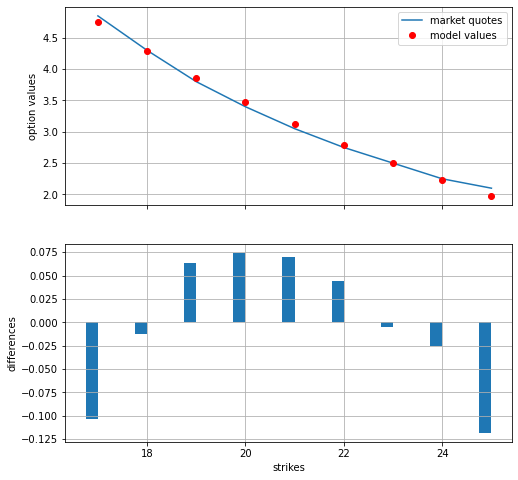

In [50]:
# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
fix, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (8, 8))
strikes = option_selection['STRIKE'].values
ax1.plot(strikes, option_selection['PRICE'], label = 'market quotes')
ax1.plot(strikes, option_selection['MODEL'], 'ro', label = 'model values')
ax1.set_ylabel('option values')
ax1.grid(True)
ax1.legend(loc = 0)
wi = 0.25
ax2.bar(strikes - wi / 2., option_selection['ERRORS'], label = 'market quotes', width = wi)
ax2.grid(True)
ax2.set_ylabel('differences')
ax2.set_xlabel('strikes')

# 19.3 VSTOXX 아메리칸 옵션

실제 시장에서 거래되지 않는, VSTOXX를 기초자산으로 하는 아메리칸 풋옵션의 가치평가

## 19.3.1 옵션 포지션 모형

In [51]:
# market_environment 객체 정의
me_vstoxx = market_environment('me_vstoxx', pricing_date)
me_vstoxx.add_constant('initial_value', initial_value)
me_vstoxx.add_constant('final_date', pricing_date)
me_vstoxx.add_constant('currency', 'NONE')

In [52]:
# 앞서 구한 최적 파라미터값 사용
me_vstoxx.add_constant('kappa', opt_local[0])
me_vstoxx.add_constant('theta', opt_local[1])
me_vstoxx.add_constant('volatility', opt_local[2])

In [53]:
me_vstoxx.add_constant('model', 'srd')
payoff_func = 'np.maximum(strike - instrument_values, 0)'

In [54]:
shared = market_environment('share', pricing_date)
shared.add_constant('maturity', maturity)
shared.add_constant('currency', 'EUR')

In [55]:
option_positions = {}
option_environments = {}

for option in option_selection.index:
    option_environments[option] = market_environment('am_put_%d' % option, pricing_date)
        # 각각의 옵션에 대해 새로운 옵션 환경 정의
    strike = option_selection['STRIKE'].loc[option]
        # 관련 행사가 선택
    option_environments[option].add_constant('strike', strike)
        # 환경에 추가
    option_environments[option].add_environment(shared)
        # 공통 데이터 추가
    option_positions['am_put_%d' % strike] = derivatives_position('am_put_%d' % strike,
                                                                  quantity = 100,
                                                                  underlying = 'vstoxx_model',
                                                                  mar_env = option_environments[option],
                                                                  otype = 'American',
                                                                  payoff_func = payoff_func)

## 19.3.2 옵션 포트폴리오

In [56]:
val_env = market_environment('val_env', pricing_date)
val_env.add_constant('starting_date', pricing_date)
val_env.add_constant('final_date', pricing_date)
# 추후 갱신되는 임시 값들
val_env.add_curve('discount_curve', csr)
val_env.add_constant('frequency', 'B')
val_env.add_constant('paths', 25000)

In [57]:
underlyings = {'vstoxx_model' : me_vstoxx}

In [58]:
portfolio = derivatives_portfolio('portfolio', option_positions, val_env, underlyings)

In [59]:
%time results = portfolio.get_statistics(fixed_seed = True)

Wall time: 37.5 s


In [62]:
results.sort_index()

,name,quant,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_17,100,4.570485,EUR,457.0485,-27.67,107.80
1,am_put_18,100,5.190628,EUR,519.0628,-30.62,108.97
2,am_put_19,100,5.862681,EUR,586.2681,-33.99,108.96
3,am_put_20,100,6.565225,EUR,656.5225,-34.92,111.54
4,am_put_21,100,7.306526,EUR,730.6526,-40.01,106.86
5,am_put_22,100,8.073473,EUR,807.3473,-41.78,106.18
6,am_put_23,100,8.858895,EUR,885.8895,-42.92,104.72
7,am_put_24,100,9.667220,EUR,966.7220,-44.24,96.04
8,am_put_25,100,10.464026,EUR,1046.4026,-42.09,102.14


In [63]:
results[['pos_value', 'pos_delta', 'pos_vega']].sum()

pos_value    6655.9159
pos_delta    -338.2400
pos_vega      953.2100
dtype: float64